# 필요 라이브러리 import

In [10]:
import pandas as pd                                          #데이터 분석 라이브러리
from sklearn.decomposition import PCA                        #주성분 분석 라이브러리
import numpy as np                                           # 계산 라이브러리
from sklearn.preprocessing import MinMaxScaler               # 최소 최대 0~1 범위로 변환을 위한 라이브러리

from sklearn.model_selection import train_test_split         # 데이터 분할 라이브러리
from sklearn.model_selection import cross_validate           # Kfold 라이브러리
from sklearn.model_selection import cross_val_score          # Kfold 라이브러리
from sklearn.model_selection import StratifiedKFold          # Kfold 라이브러리


from sklearn.neighbors import KNeighborsClassifier           # KNN 라이브러리
from sklearn.svm import SVC                                  # SVM Classifier 라이브러리
from sklearn.tree import DecisionTreeClassifier              # 결정나무분류 라이브러리
from sklearn.linear_model import LogisticRegression          # 로지스틱 회귀 라이브러리
from bayes_opt import BayesianOptimization                   # 베이시안 라이브러리   


from sklearn.metrics import make_scorer                      # 평가용 라이브러리
from sklearn.metrics import f1_score                         # f1  라이브러리
from sklearn.metrics import accuracy_score                   # accuracy 라이브러리 



import matplotlib.pyplot as plt                              # 그래프 라이브러리
from sklearn.ensemble import VotingClassifier                # 보팅 앙상블 라이브러리
import seaborn as sns                                        # boxplot 을 위한 라이브러리

# data 불러오기

In [58]:
File = pd.read_csv("../../Data/final_data/training/geo_data/geo_training_data.csv")

In [12]:
Floodfile = File.drop(columns='FLOOD')
Floodclass = File['FLOOD']

In [13]:
Floodfile

,PUMP_RATIO,Hourly_Rainfall_Weight,Impervious_Surface_Weight,SLOPE_AVG_Weight,HIGH_Weight,F_WEIGHT
0,1.485884e-08,0.076087,0.955239,0.599952,0.024868,0.149925
1,1.485884e-08,0.184783,0.955239,0.599952,0.024868,0.149925
2,1.485884e-08,0.254902,0.955239,0.599952,0.024868,0.149925
3,1.485884e-08,0.443182,0.955239,0.599952,0.024868,0.149925
4,0.000000e+00,0.076087,0.460742,2.699784,0.039186,0.075019
...,...,...,...,...,...,...
791,1.189961e-08,0.259722,0.609000,0.599952,0.022231,0.075019
792,1.189961e-08,0.208696,0.609000,0.599952,0.014820,0.075019
793,1.189961e-08,0.259722,0.609000,0.599952,0.014820,0.075019
794,1.189961e-08,0.208696,0.609000,0.599952,0.019719,0.075019


# minmaxscaler
## data scale 과정

In [14]:
scaler = MinMaxScaler()
scaler.fit(Floodfile)
Floodfile = scaler.transform(Floodfile)

# PCA

In [15]:
pca = PCA(n_components=4) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(Floodfile)
Floodfile = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2','principal component3', 'principal component4'])

In [16]:
Floodfile

,principal component1,principal component2,principal component3,principal component4
0,0.849904,-0.064720,-0.089274,0.212249
1,0.844367,-0.011832,-0.012114,0.054534
2,0.840795,0.022286,0.037663,-0.047209
3,0.831204,0.113897,0.171318,-0.320400
4,0.138355,0.150459,-0.449484,0.228843
...,...,...,...,...
791,0.203026,0.007809,-0.201331,-0.122226
792,0.205626,-0.017019,-0.237554,-0.048187
793,0.203026,0.007809,-0.201332,-0.122226
794,0.205625,-0.017019,-0.237554,-0.048187


# data split
## 8 : 2 으로 training 과 test 구분

In [17]:
x_train, x_test, y_train, y_test = train_test_split(Floodfile, Floodclass , test_size=0.2, random_state=400)

In [18]:
skfolds=StratifiedKFold(n_splits=3, random_state=400 ,shuffle = True)

# BayesianOptimization

## KNN

In [19]:
KNN_search_point = {'k': (3,50), 'leaf': (1,50)}

gp_params = {"alpha":1e-10}
scores_all = []
k_all = []
leaf_all=[]

def KNN_opt(k,leaf):
    cvscores = []
    
    for train_index, val_index in skfolds.split(x_train, y_train):
#         print(train_index)
#         print(val_index)
        x_skftrain, x_val = x_train.values[train_index], x_train.values[val_index]
        Y_skftrain, Y_val = np.array(y_train)[train_index],np.array(y_train)[val_index]
        
        KNNmodel = KNeighborsClassifier(n_neighbors = int(k),weights = 'distance', leaf_size= leaf ) # KNN  
        
        KNNmodel2 = KNNmodel.fit(x_skftrain,Y_skftrain)      # 모델학습
        y_pred = KNNmodel2.predict(x_val)                    # 예측

        report = f1_score(Y_val, y_pred, average='weighted') # F1
#         report = accuracy_score(Y_val, y_pred)             # accuracy
        cvscores.append(report)
    
    
    scores_all.append(np.mean(cvscores))
    k_all.append(int(k))
#     leaf_all.append(int(leaf))
    
    return np.mean(cvscores)

result = BayesianOptimization(KNN_opt, KNN_search_point,    random_state=10,    verbose=2) 
result.maximize(acq='ucb',n_iter=15, kappa=2.576, init_points=1 , **gp_params)

|   iter    |  target   |     k     |   leaf    |
-------------------------------------------------
|  1        |  0.8117   |  39.25    |  2.017    |
|  2        |  0.8117   |  26.48    |  25.79    |
|  3        |  0.8029   |  3.535    |  1.568    |
|  4        |  0.8033   |  49.9     |  49.91    |
|  5        |  0.8085   |  43.62    |  3.369    |
|  6        |  0.8029   |  3.787    |  49.76    |
|  7        |  0.8117   |  26.18    |  49.9     |
|  8        |  0.8117   |  26.17    |  45.31    |
|  9        |  0.8102   |  24.29    |  1.107    |
|  10       |  0.8105   |  22.09    |  47.76    |
|  11       |  0.8115   |  38.21    |  26.06    |
|  12       |  0.8102   |  33.22    |  10.83    |
|  13       |  0.8102   |  33.8     |  35.79    |
|  14       |  0.8029   |  3.055    |  25.48    |
|  15       |  0.8116   |  35.7     |  49.85    |
|  16       |  0.8149   |  30.46    |  47.7     |


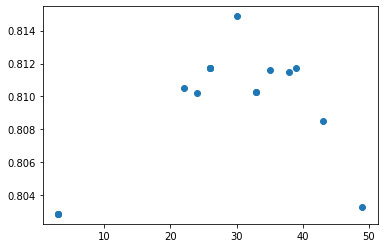

In [20]:
plt.scatter(k_all, scores_all)

## SVM

In [21]:
SVM_search_point = {'k': (1,50), 'gamma': (0.001,20)}

gp_params = {"alpha":1e-10}
scores_all = []
k_all = []
gamma_all = []
def SVM_opt(k,gamma):
    cvscores = []
    
    for train_index, val_index in skfolds.split(x_train, y_train):
        x_skftrain, x_val = x_train.values[train_index],x_train.values[val_index]
        Y_skftrain, Y_val = np.array(y_train)[train_index],np.array(y_train)[val_index]

        SVMmodel = SVC( C= int(k) , kernel='rbf' , probability = True, gamma = gamma ) # SVM  
        
        SVMmodel2 = SVMmodel.fit(x_skftrain,Y_skftrain)      # 모델학습
        y_pred = SVMmodel2.predict(x_val)                    # 예측

        report = f1_score(Y_val, y_pred, average='weighted') # F1
#         report = accuracy_score(Y_val, y_pred)             # accuracy
        cvscores.append(report)
    
    scores_all.append(np.mean(cvscores))
    k_all.append(int(k))
    return np.mean(cvscores)

result = BayesianOptimization(SVM_opt, SVM_search_point, random_state=10, verbose=2) 
result.maximize(acq='ucb',n_iter=15, kappa=2.576, init_points=1 , **gp_params)

|   iter    |  target   |   gamma   |     k     |
-------------------------------------------------
|  1        |  0.7571   |  15.43    |  2.017    |
|  2        |  0.7613   |  9.991    |  25.79    |
|  3        |  0.7912   |  19.93    |  49.36    |
|  4        |  0.7912   |  19.96    |  49.91    |
|  5        |  0.7867   |  19.93    |  36.24    |
|  6        |  0.7602   |  0.6069   |  49.91    |
|  7        |  0.7897   |  19.86    |  47.3     |
|  8        |  0.4857   |  0.001    |  1.0      |
|  9        |  0.7681   |  19.9     |  13.9     |
|  10       |  0.7642   |  19.86    |  1.048    |
|  11       |  0.756    |  11.14    |  49.8     |
|  12       |  0.722    |  0.008823 |  38.07    |
|  13       |  0.7821   |  19.99    |  25.57    |
|  14       |  0.7634   |  14.9     |  32.76    |
|  15       |  0.7578   |  13.15    |  15.88    |
|  16       |  0.7836   |  19.97    |  30.96    |


In [22]:
SVM_search_point = {'k': (1,50)}

gp_params = {"alpha":1e-10}
scores_all = []
k_all = []
gamma_all = []
def SVM_opt(k):
    cvscores = []
    
    for train_index, val_index in skfolds.split(x_train, y_train):
        x_skftrain, x_val = x_train.values[train_index],x_train.values[val_index]
        Y_skftrain, Y_val = np.array(y_train)[train_index],np.array(y_train)[val_index]

        SVMmodel = SVC( C= int(k) , kernel='poly' , probability = True ) # SVM  
        
        SVMmodel2 = SVMmodel.fit(x_skftrain,Y_skftrain)      # 모델학습
        y_pred = SVMmodel2.predict(x_val)                    # 예측

        report = f1_score(Y_val, y_pred, average='weighted') # F1
#         report = accuracy_score(Y_val, y_pred)             # accuracy
        cvscores.append(report)
    
    scores_all.append(np.mean(cvscores))
    k_all.append(int(k))
    return np.mean(cvscores)

result = BayesianOptimization(SVM_opt, SVM_search_point, random_state=10, verbose=2) 
result.maximize(acq='ucb',n_iter=15, kappa=2.576, init_points=1 , **gp_params)

|   iter    |  target   |     k     |
-------------------------------------
|  1        |  0.7137   |  38.79    |
|  2        |  0.7123   |  18.73    |
|  3        |  0.7137   |  49.94    |
|  4        |  0.7084   |  1.006    |
|  5        |  0.7116   |  44.46    |
|  6        |  0.7144   |  28.51    |
|  7        |  0.7159   |  9.241    |
|  8        |  0.7116   |  33.2     |
|  9        |  0.7141   |  5.777    |
|  10       |  0.7123   |  24.39    |
|  11       |  0.7123   |  13.19    |
|  12       |  0.7172   |  8.031    |
|  13       |  0.713    |  47.95    |
|  14       |  0.7186   |  7.669    |
|  15       |  0.7123   |  21.45    |
|  16       |  0.7116   |  36.15    |


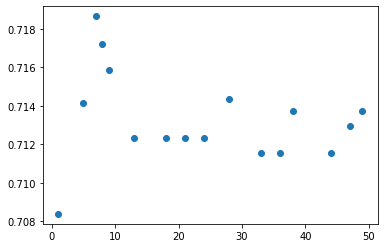

In [23]:
plt.scatter(k_all, scores_all)

## Decision Tree

In [24]:
DT_search_point = { 'k': (1,30), 'leaf' : ( 2, 30), 'split': (2,30) }

gp_params = {"alpha":1e-10}
scores_all = []
k_all = []
leaf_all = []
split_all = []

def DT_opt(k,leaf,split):
    cvscores = []
    
    for train_index, val_index in skfolds.split(x_train, y_train):
        x_skftrain, x_val = x_train.values[train_index],x_train.values[val_index]
        Y_skftrain, Y_val = np.array(y_train)[train_index],np.array(y_train)[val_index]

        DTmodel = DecisionTreeClassifier(criterion='gini',
                                         max_depth=int(k),              # 트리의 최대 깊이
                                         min_samples_leaf= int(leaf),
                                         min_samples_split= int(split)) #DT  
        
        
        DTmodel2 = DTmodel.fit(x_skftrain,Y_skftrain)      # 모델학습
        y_pred = DTmodel2.predict(x_val)                    # 예측

        report = f1_score(Y_val, y_pred, average='weighted') # F1
#         report = accuracy_score(Y_val, y_pred)             # accuracy
        cvscores.append(report)
    
    scores_all.append(np.mean(cvscores))
    k_all.append(int(k))
    leaf_all.append(int(leaf))
    split_all.append(split)

    
    return np.mean(cvscores)

result = BayesianOptimization(DT_opt, DT_search_point, random_state=10, verbose=2) 
result.maximize(acq='ucb',n_iter=15, kappa=2.576, init_points=1 , **gp_params)

|   iter    |  target   |     k     |   leaf    |   split   |
-------------------------------------------------------------
|  1        |  0.7761   |  23.37    |  2.581    |  19.74    |
|  2        |  0.7409   |  26.25    |  23.01    |  19.33    |
|  3        |  0.709    |  1.0      |  2.0      |  2.0      |
|  4        |  0.709    |  1.0      |  2.0      |  30.0     |
|  5        |  0.7674   |  30.0     |  2.0      |  30.0     |
|  6        |  0.7665   |  29.77    |  3.831    |  2.301    |
|  7        |  0.7781   |  29.54    |  2.401    |  16.02    |
|  8        |  0.7851   |  26.4     |  3.383    |  17.79    |
|  9        |  0.709    |  1.555    |  29.51    |  3.868    |
|  10       |  0.709    |  1.857    |  28.42    |  29.14    |
|  11       |  0.7587   |  18.89    |  15.78    |  2.405    |
|  12       |  0.7472   |  24.62    |  12.88    |  29.98    |
|  13       |  0.7205   |  29.65    |  29.54    |  3.266    |
|  14       |  0.709    |  1.165    |  14.64    |  15.46    |
|  15   

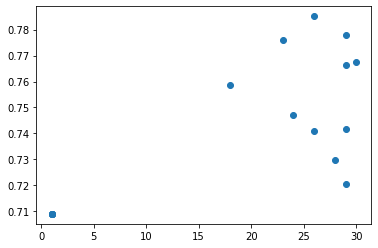

In [25]:
plt.scatter(k_all, scores_all)

## Logistic Regression

In [26]:
LR_search_point = { 'k': (1,50)}

gp_params = {"alpha":1e-10}
scores_all = []
k_all = []

def LR_opt(k):
    cvscores = []
    
    for train_index, val_index in skfolds.split(x_train, y_train):
        x_skftrain, x_val = x_train.values[train_index],x_train.values[val_index]
        Y_skftrain, Y_val = np.array(y_train)[train_index],np.array(y_train)[val_index]

        LRmodel = LogisticRegression(C= int(k) , multi_class= 'auto') #LR  
        
        
        LRmodel2 = LRmodel.fit(x_skftrain,Y_skftrain)      # 모델학습
        y_pred = LRmodel2.predict(x_val)                    # 예측

        report = f1_score(Y_val, y_pred, average='weighted') # F1
#         report = accuracy_score(Y_val, y_pred)             # accuracy
        cvscores.append(report)
    
    scores_all.append(np.mean(cvscores))
    k_all.append(int(k))
    
    return np.mean(cvscores)

result = BayesianOptimization(LR_opt, LR_search_point, random_state=10, verbose=2) 
result.maximize(acq='ucb',n_iter=15, kappa=2.576, init_points=1 , **gp_params)

|   iter    |  target   |     k     |
-------------------------------------
|  1        |  0.7275   |  38.79    |
|  2        |  0.7275   |  18.73    |
|  3        |  0.7291   |  3.376    |
|  4        |  0.7314   |  8.702    |
|  5        |  0.7275   |  50.0     |
|  6        |  0.7289   |  11.05    |
|  7        |  0.7275   |  29.34    |
|  8        |  0.7275   |  45.25    |
|  9        |  0.7314   |  6.33     |
|  10       |  0.7275   |  23.97    |
|  11       |  0.7314   |  7.492    |
|  12       |  0.7275   |  34.2     |
|  13       |  0.7314   |  7.87     |
|  14       |  0.7314   |  7.697    |
|  15       |  0.7314   |  6.976    |
|  16       |  0.7314   |  8.006    |


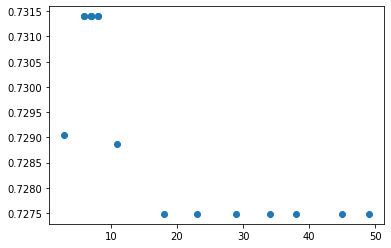

In [27]:
plt.scatter(k_all, scores_all)

# Voting ensemble
## 사용 된 모델 : KNN, SVM, Decision Tree, Logistic Regression

In [28]:
KNN_model = KNeighborsClassifier(n_neighbors = 21,weights = 'distance', leaf_size=49)

SVM_model = SVC( C= 29 , kernel='rbf' , probability = True , gamma = 30 )

DT_model = DecisionTreeClassifier(criterion='gini', max_depth=28, min_samples_leaf= 5, min_samples_split= 2)

LR_model = LogisticRegression(C= 5, multi_class= 'auto')

In [29]:
KNN_model = KNeighborsClassifier()

SVM_model = SVC(probability = True )

DT_model = DecisionTreeClassifier()

LR_model = LogisticRegression()

In [30]:
ensemble=VotingClassifier(
        estimators=[('KNN',KNN_model),
                   ('SVM',SVM_model),
                   ('DT',DT_model),
                   ('LR',LR_model)]
        ,voting='soft')

# Voting 모델 안에 각 모델들을 묶어주기

In [31]:
KNN_model.fit(x_train,y_train)
SVM_model.fit(x_train,y_train)
DT_model.fit(x_train,y_train)
LR_model.fit(x_train,y_train)
ensemble.fit(x_train,y_train)

# 각 모델들을 데이터로 학습시키기

VotingClassifier(estimators=[('KNN',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=5,
                                                   p=2, weights='uniform')),
                             ('SVM',
                              SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='rbf', max_iter=-1,
                                  probability=True, ran...
                                                     presort='deprecated',
                                                     random_state=None

# 교차검증 적용

In [32]:
SKF = StratifiedKFold( n_splits = 3,  shuffle = True, random_state = 16)

In [33]:
KNN_scores=cross_validate(KNN_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
SVM_scores=cross_validate(SVM_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
DT_scores=cross_validate(DT_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
LR_scores=cross_validate(LR_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
ensemble_scores=cross_validate(ensemble, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))

In [34]:
print(KNN_scores)
print(SVM_scores)
print(DT_scores)
print(LR_scores)
print(ensemble_scores)

{'fit_time': array([0.00291896, 0.00389552, 0.00474072]), 'score_time': array([0.05946898, 0.01009035, 0.01657605]), 'test_score': array([0.62025316, 0.70588235, 0.73417722])}
{'fit_time': array([0.03355718, 0.02996659, 0.02945876]), 'score_time': array([0.00291467, 0.00388288, 0.00291467]), 'test_score': array([0.56060606, 0.66225166, 0.69117647])}
{'fit_time': array([0.00158358, 0.00475073, 0.00193405]), 'score_time': array([0.00195169, 0.00090647, 0.00096846]), 'test_score': array([0.64102564, 0.725     , 0.7483871 ])}
{'fit_time': array([0.00382733, 0.00458932, 0.00295401]), 'score_time': array([0.00102091, 0.00097322, 0.00097322]), 'test_score': array([0.48854962, 0.57777778, 0.68181818])}
{'fit_time': array([0.02193618, 0.03087211, 0.02643323]), 'score_time': array([0.00486684, 0.00707126, 0.00587106]), 'test_score': array([0.61111111, 0.6993865 , 0.78378378])}


In [35]:
KNN_f1_score = KNN_scores["test_score"].mean()
SVN_f1_score = SVM_scores["test_score"].mean()
DT_f1_score = DT_scores["test_score"].mean()
LR_f1_score = LR_scores["test_score"].mean()
ensemble_f1_score = ensemble_scores["test_score"].mean()


print("f1_score: {0: .4f}".format(KNN_f1_score))
print("f1_score: {0: .4f}".format(SVN_f1_score))
print("f1_score: {0: .4f}".format(DT_f1_score))
print("f1_score: {0: .4f}".format(LR_f1_score))
print("f1_score: {0: .4f}".format(ensemble_f1_score))

f1_score:  0.6868
f1_score:  0.6380
f1_score:  0.7048
f1_score:  0.5827
f1_score:  0.6981


# 결과 boxplot

[Text(1, 0, 'KNN'),
 Text(2, 0, 'SVM'),
 Text(3, 0, 'DT'),
 Text(4, 0, 'LR'),
 Text(5, 0, 'Voting')]

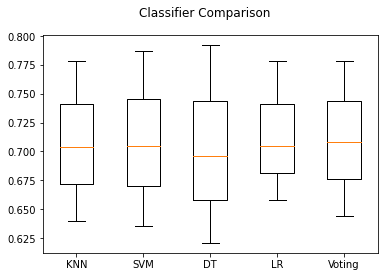

In [36]:
results = []
names = []

models = []
models.append(('KNN', KNN_model))
models.append(('SVM', SVM_model))
models.append(('DT', DT_model))
models.append(('LR', LR_model))
models.append(('Voting',ensemble))


for name, model in models:
    kfold = StratifiedKFold( n_splits = 3,  shuffle = True, random_state = 10)
#     cv_results = cross_validate(ensemble, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
    cv_results = cross_val_score(ensemble, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
    results.append(cv_results)
    names.append(name)

fig = plt.figure()
fig.suptitle('Classifier Comparison')
ax= fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

# test 데이터 예측

In [37]:
pred_KNN = KNN_model.predict(x_test)
pred_SVM = SVM_model.predict(x_test)
pred_DT = DT_model.predict(x_test)
pred_LR = LR_model.predict(x_test)

# 각 모델들의 f1_score 파악을 위해 모델들 예측실행

In [38]:
y_predict= ensemble.predict(x_test)

# 적용 모델인 Voting ensemble 예측

# Test data 교차검증 boxplot

[Text(1, 0, 'KNN'),
 Text(2, 0, 'SVM'),
 Text(3, 0, 'DT'),
 Text(4, 0, 'LR'),
 Text(5, 0, 'Voting')]

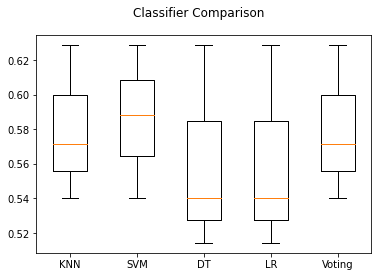

In [39]:
results = []
names = []

models = []
models.append(('KNN', KNN_model))
models.append(('SVM', SVM_model))
models.append(('DT', DT_model))
models.append(('LR', LR_model))
models.append(('Voting',ensemble))


for name, model in models:
    kfold = StratifiedKFold( n_splits = 3,  shuffle = True, random_state = 10)
#     cv_results = cross_validate(ensemble, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
    cv_results = cross_val_score(ensemble, x_test, y_test, cv=SKF, scoring=make_scorer(f1_score))
    results.append(cv_results)
    names.append(name)

fig = plt.figure()
fig.suptitle('Classifier Comparison')
ax= fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

# 2020 년 사고사례 데이터

# DATA 불러오기

In [40]:
accident = pd.read_excel("./초량동 지형 강우량.xlsx")   # 초량지하차도 지형정보 와 당일 시간당 강우량 데이터

In [41]:
Busanaccident = accident.drop(['SLOPE_L','SLOPE_H','FLOOD','MANHOLES_RATIO'], axis = 1)  # 불필요 컬럼제거
Busanaccidentclass = accident['FLOOD']                                                  # 분류구분

# 가중치 주기

In [42]:
Busanaccident.rename(columns={'R_W_SUM':'Hourly_Rainfall_Weight','HOUR_RAINFALL':'Hourly_Rainfall','IMP_SUR_RATIO':'Impervious_Surface',
                              'IMP_W_SUM':'Impervious_Surface_Weight'},inplace=True)  # 컬럼명 수정

In [43]:
Busanaccident

,SLOPE_AVG,HIGH,PUMP_RATIO,Impervious_Surface,Hourly_Rainfall,F_WEIGHT,Hourly_Rainfall_Weight,Impervious_Surface_Weight
0,1,4,1.982160e-07,57.92,0.0,0.017,0.000,3.99648
1,1,4,1.982160e-07,57.92,0.0,0.017,0.000,3.99648
2,1,4,1.982160e-07,57.92,0.0,0.017,0.000,3.99648
3,1,4,1.982160e-07,57.92,0.0,0.017,0.000,3.99648
4,1,4,1.982160e-07,57.92,0.5,0.017,0.005,3.99648
5,1,4,1.982160e-07,57.92,0.0,0.017,0.000,3.99648
6,1,4,1.982160e-07,57.92,0.0,0.017,0.000,3.99648
7,1,4,1.982160e-07,57.92,1.0,0.017,0.010,3.99648
8,1,4,1.982160e-07,57.92,3.5,0.017,0.035,3.99648
9,1,4,1.982160e-07,57.92,0.0,0.017,0.000,3.99648


In [44]:
rain_weight= Busanaccident['Hourly_Rainfall'].copy()
imp_weight = Busanaccident['Impervious_Surface'].copy()
slope_weight = Busanaccident['SLOPE_AVG'].copy()
high_weight = Busanaccident['HIGH'].copy()

## 강우량 가중치

In [45]:
for idx,col in enumerate(Busanaccident['Hourly_Rainfall']):
    if col <= 15:
        rain_weight[idx] = col / (46)
    elif col > 15 and col <= 35:
        rain_weight[idx] = col / (18 * 2**2)
    elif col > 35 and col <= 60:
        rain_weight[idx] = col / (17 * 3**2)
    elif col > 60 and col <= 80:
        rain_weight[idx] = col / (11 * 4**2)
    elif col > 80:
        rain_weight[idx] = col / (6.28 * 5**2)

 ## 불투수면 가중치

In [46]:
for idx,col in enumerate(Busanaccident['Impervious_Surface']):
    if col <= 15:
        imp_weight[idx] = col / 6.66
    elif col > 15 and col <= 25:
        imp_weight[idx] = col / (20 * 2)
    elif col > 25 and col <= 40:
        imp_weight[idx] = col / (13.33 * 3)
    elif col > 40 and col <= 55:
        imp_weight[idx] = col / (33.33 * 4)
    elif col > 55:
        imp_weight[idx] = col / (26.67 * 5)

 ## 경사도 가중치

In [47]:
Busanaccident['SLOPE_AVG_Weight'] = Busanaccident['SLOPE_AVG'].copy()

In [48]:
for idx,col in enumerate(Busanaccident['SLOPE_AVG']):
    if col <= 10:
        slope_weight[idx] = col / (41.67 / 5**2 )
    elif col > 10 and col <= 15:
        slope_weight[idx] = col / (25 / 4**2)
    elif col > 15 and col <= 25:
        slope_weight[idx] = col / (16.67 / 3**2)
    elif col > 25 and col <= 50:
        slope_weight[idx] = col / (8.33 / 2**2)
    elif col > 50:
        slope_weight[idx] = col / (8.33 / 1**2)

## 고도 가중치

In [49]:
Busanaccident['HIGH_Weight'] = Busanaccident['HIGH'].copy()

In [50]:
for idx,col in enumerate(Busanaccident['HIGH']):
    if col <= 20:
        high_weight[idx] = col / (79.62 / 1**2)
    elif col > 20 and col <= 40:
        high_weight[idx] = col / (10.18 / 2**2)
    elif col > 40 and col <= 60:
        high_weight[idx] = col / (4.63 / 3**2)
    elif col > 60 and col <= 80:
        high_weight[idx] = col / (2.78 / 4**2)
    elif col > 80:
        high_weight[idx] = col / (2.78 / 5**2)

In [51]:
Busanaccident['Hourly_Rainfall_Weight'] = rain_weight
Busanaccident['Impervious_Surface_Weight'] = imp_weight
Busanaccident['SLOPE_AVG_Weight'] = slope_weight
Busanaccident['HIGH_Weight'] = high_weight

In [52]:
Busanaccident = Busanaccident.drop(['SLOPE_AVG','Impervious_Surface','Hourly_Rainfall','HIGH'], axis = 1)
Busanaccident

,PUMP_RATIO,F_WEIGHT,Hourly_Rainfall_Weight,Impervious_Surface_Weight,SLOPE_AVG_Weight,HIGH_Weight
0,1.982160e-07,0.017,0.000000,0.434346,0,0
1,1.982160e-07,0.017,0.000000,0.434346,0,0
2,1.982160e-07,0.017,0.000000,0.434346,0,0
3,1.982160e-07,0.017,0.000000,0.434346,0,0
4,1.982160e-07,0.017,0.010870,0.434346,0,0
5,1.982160e-07,0.017,0.000000,0.434346,0,0
6,1.982160e-07,0.017,0.000000,0.434346,0,0
7,1.982160e-07,0.017,0.021739,0.434346,0,0
8,1.982160e-07,0.017,0.076087,0.434346,0,0
9,1.982160e-07,0.017,0.000000,0.434346,0,0


In [53]:
scaler = MinMaxScaler()
scaler.fit(Busanaccident)
Busanaccident = scaler.transform(Busanaccident)                         # sccler 적용

# PCA 적용

In [54]:
pca = PCA(n_components=4)
printcipalComponents = pca.fit_transform(Busanaccident)
Busanaccident = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2','principal component3', 'principal component4'])

# 예측값 확인

In [55]:
accident_predict= ensemble.predict(Busanaccident)                       # 위에서 학습된 모델 활용을 이용한 예측

In [56]:
print(accident_predict)                                                 # 예측값 확인

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
